In [1]:
import torch
import VGG_FACE
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
import glob
import numpy as np
import re
import torch.nn.functional as F
import pandas as pd
import string
import json
from collections import OrderedDict

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [95]:
im = Image.open('all-data/vids/imgs_elf/faces/scene01009face3.jpg')
im.size

(49, 49)

In [4]:
def greyscaleToRGB(image):
    im = imgTransform(image) #spits out a tensor
    npIm = im.numpy()[0]
    npIm = np.stack((npIm, npIm, npIm))
    #npim = np.expand_dims(npim, 0)
    return Variable(torch.from_numpy(npIm).unsqueeze(0), volatile = True)



In [101]:
model = VGG_FACE.VGG_FACE

im = Image.open('all-data/vids/imgs_elf/faces/scene01009face3.jpg')
inputVar =  Variable(preprocessFn(im).unsqueeze(0), volatile=True)
predictions = modified_pretrained(inputVar)

print(predictions)

pretrained_model = model
#print(pretrained_model)
#print(list(pretrained_model.children())[:-2]) #gets rid of the last linear layer and softmax
modified_pretrained = nn.Sequential(*list(pretrained_model.children())[:-2]) 

#print(modified_pretrained)

modified_pretrained.add_module('38', nn.Sequential(VGG_FACE.Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,3)))
modified_pretrained.add_module('39', nn.Softmax())

print(modified_pretrained)

Variable containing:
 0.3291  0.3343  0.3367
[torch.FloatTensor of size 1x3]

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU ()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU ()
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU ()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU ()
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU ()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU ()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU ()
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU 

In [6]:
modified_pretrained.load_state_dict(torch.load('trained_model.pth',map_location=lambda storage, loc: storage))
modified_pretrained.eval()
#print(model.parameters().size())

#for param in model.parameters():
    #print(param, param.data)

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU ()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU ()
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU ()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU ()
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU ()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU ()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU ()
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU ()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
faces = glob.glob('all-data/vids/imgs_elf/faces/*.jpg')
faces.sort(key=natural_keys)


In [60]:
# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256), #scale to 256x256
                                   transforms.CenterCrop(224), #crops the image at center to 224x224
                                   transforms.ToTensor()])

# 2. Load the emotion class names.
names = pd.read_csv('vgg_face_torch/emotions.txt', sep="\n", header=None).iloc[:, 0].values

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
modified_pretrained.eval()
face_preds = OrderedDict()
totalCount = 0
filteredCount = 0
#add all images to a list as numpy tensor
for image in faces:
    totalCount += 1
    if totalCount >0 and totalCount < 100000000000:
        if totalCount%100==0: print(totalCount)
        # unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
        im = Image.open(image).convert('RGB')
        if (im.size > (75,75)):
            filteredCount += 1
            inputVar =  Variable(preprocessFn(im).unsqueeze(0), volatile=True)
            predictions = modified_pretrained(inputVar)
            probs, indices = (-F.softmax(predictions)).data.sort()
            probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
            face_preds[image] = (probs, indices)

        im.close()

print(totalCount)
print(filteredCount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3657
2353


('total count = ', 3657)
('facePreds length:', 2353)
100
all-data/vids/imgs_elf/faces/scene08353face1.jpg
(array([ 0.33512989,  0.33342245,  0.33144766], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene08353face1.jpg
(132, 132)


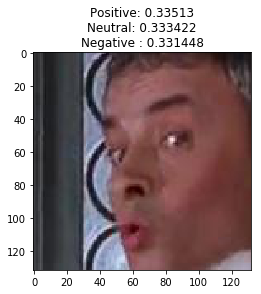

200
all-data/vids/imgs_elf/faces/scene13297face1.jpg
(array([ 0.33478746,  0.3340227 ,  0.33118984], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene13297face1.jpg
(360, 361)


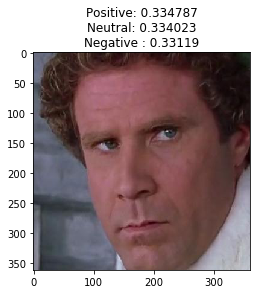

300
all-data/vids/imgs_elf/faces/scene20305face1.jpg
(array([ 0.33508831,  0.33323491,  0.33167678], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene20305face1.jpg
(194, 195)


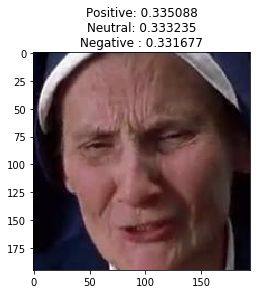

400
all-data/vids/imgs_elf/faces/scene28753face1.jpg
(array([ 0.33500645,  0.333547  ,  0.33144656], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene28753face1.jpg
(82, 82)


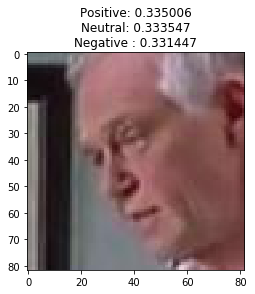

500
all-data/vids/imgs_elf/faces/scene31825face1.jpg
(array([ 0.33463201,  0.33319712,  0.33217087], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene31825face1.jpg
(191, 192)


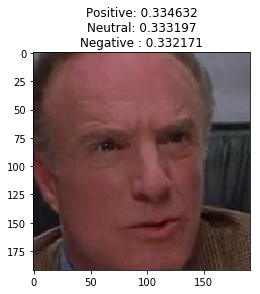

600
all-data/vids/imgs_elf/faces/scene37105face2.jpg
(array([ 0.33431706,  0.33424711,  0.33143583], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene37105face2.jpg
(96, 97)


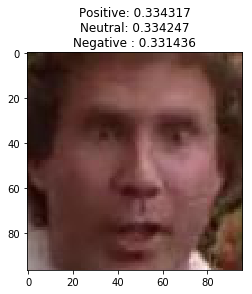

700
all-data/vids/imgs_elf/faces/scene42865face1.jpg
(array([ 0.33414406,  0.33414266,  0.33171332], dtype=float32), array([1, 2, 0]))
all-data/vids/imgs_elf/faces/scene42865face1.jpg
(108, 107)


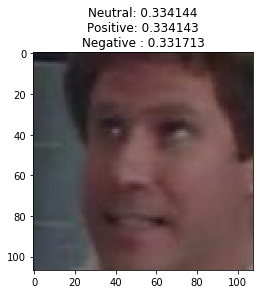

800
all-data/vids/imgs_elf/faces/scene46849face1.jpg
(array([ 0.33441487,  0.33427688,  0.33130825], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene46849face1.jpg
(194, 193)


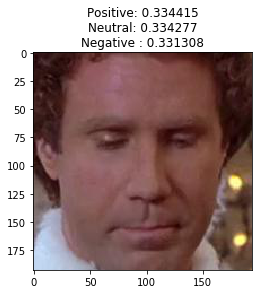

900
all-data/vids/imgs_elf/faces/scene50449face1.jpg
(array([ 0.33461508,  0.3335633 ,  0.33182162], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene50449face1.jpg
(99, 99)


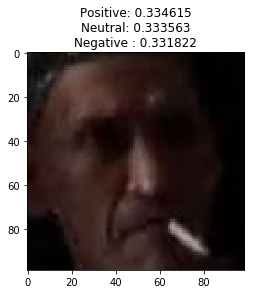

1000
all-data/vids/imgs_elf/faces/scene54385face1.jpg
(array([ 0.33466035,  0.3343496 ,  0.33099008], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene54385face1.jpg
(289, 289)


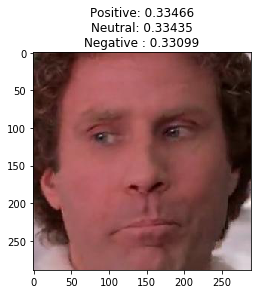

1100
all-data/vids/imgs_elf/faces/scene57985face1.jpg
(array([ 0.33424306,  0.33350533,  0.33225158], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene57985face1.jpg
(275, 274)


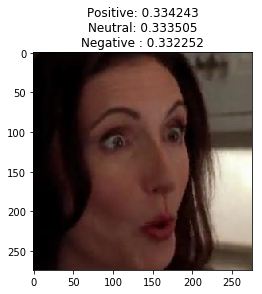

1200
all-data/vids/imgs_elf/faces/scene63553face1.jpg
(array([ 0.33468083,  0.33347222,  0.33184695], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene63553face1.jpg
(114, 112)


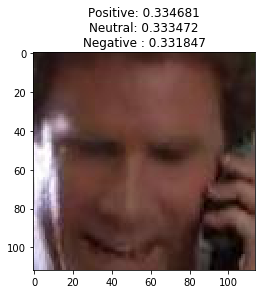

1300
all-data/vids/imgs_elf/faces/scene70417face1.jpg
(array([ 0.33433965,  0.33404168,  0.33161864], dtype=float32), array([1, 2, 0]))
all-data/vids/imgs_elf/faces/scene70417face1.jpg
(101, 100)


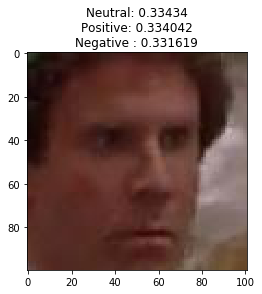

1400
all-data/vids/imgs_elf/faces/scene75361face1.jpg
(array([ 0.3341825 ,  0.33417109,  0.33164641], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene75361face1.jpg
(123, 124)


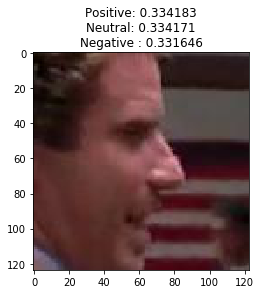

1500
all-data/vids/imgs_elf/faces/scene80161face1.jpg
(array([ 0.3343302 ,  0.33342585,  0.33224395], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene80161face1.jpg
(175, 175)


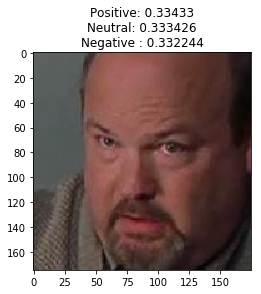

1600
all-data/vids/imgs_elf/faces/scene83665face1.jpg
(array([ 0.33455068,  0.33343354,  0.33201578], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene83665face1.jpg
(208, 205)


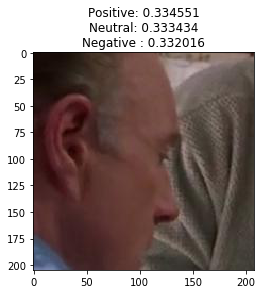

1700
all-data/vids/imgs_elf/faces/scene88897face1.jpg
(array([ 0.33393893,  0.33357182,  0.33248925], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene88897face1.jpg
(244, 244)


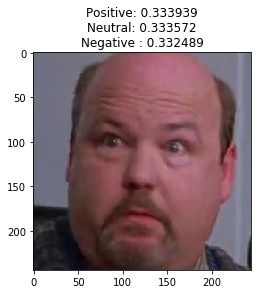

1800
all-data/vids/imgs_elf/faces/scene92833face1.jpg
(array([ 0.33416337,  0.33352494,  0.33231169], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene92833face1.jpg
(205, 206)


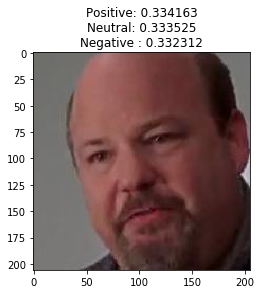

1900
all-data/vids/imgs_elf/faces/scene98977face2.jpg
(array([ 0.33432743,  0.33352134,  0.33215126], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene98977face2.jpg
(131, 131)


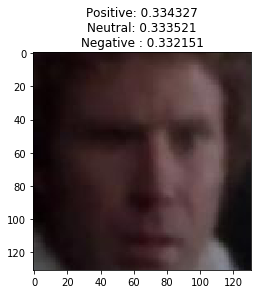

2000
all-data/vids/imgs_elf/faces/scene106177face1.jpg
(array([ 0.33448705,  0.33401284,  0.33150011], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene106177face1.jpg
(126, 126)


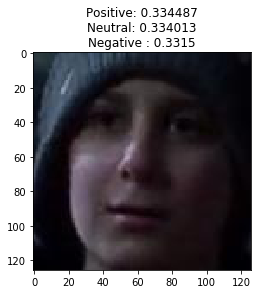

2100
all-data/vids/imgs_elf/faces/scene108913face4.jpg
(array([ 0.33433297,  0.33362794,  0.33203909], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene108913face4.jpg
(128, 128)


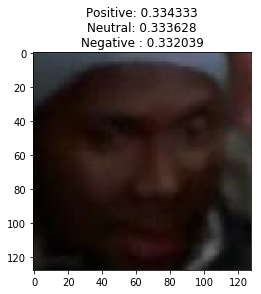

2200
all-data/vids/imgs_elf/faces/scene112033face5.jpg
(array([ 0.33452517,  0.33429083,  0.331184  ], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene112033face5.jpg
(76, 76)


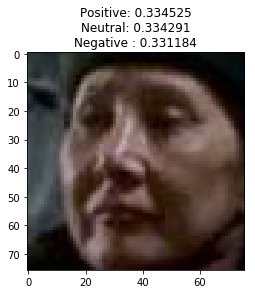

2300
all-data/vids/imgs_elf/faces/scene114625face6.jpg
(array([ 0.33465239,  0.33377677,  0.33157083], dtype=float32), array([2, 1, 0]))
all-data/vids/imgs_elf/faces/scene114625face6.jpg
(77, 78)


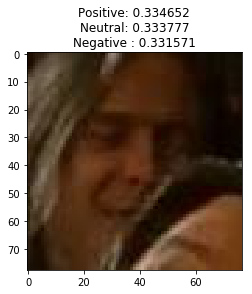

2353


In [89]:
print("total count = ", totalCount)
print("facePreds length:", len(face_preds))
#print(faces_probs)
#print(faces_indices)

scene_emotion = []
count = 0
for filename, probsIndices in face_preds.items():
    count += 1
    
        
    probs = probsIndices[0]
    indices = probsIndices[1]
    
    #put scene number and emotion in list to prepare for graphing
    scene_emotion.append((int(filename.split('scene')[1].split('face')[0]),indices[0]))
    
    if count%100==0:
        print(count)
        print(filename)
        print(probsIndices)
        #print out top predictions to display results
        preds = [names[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
        print(filename)
        # 5. Show image and predictions
        plt.title(string.join(preds,'\n'))
        image = Image.open(filename)
        plt.imshow(image)
        plt.show(image) 
    
print(len(scene_emotion))

In [80]:
print(len(scene_emotion))

2353


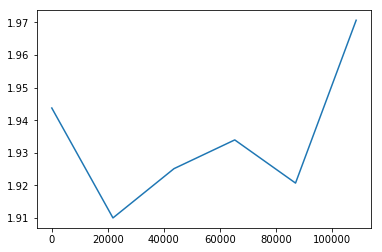

In [85]:
from matplotlib import axes

#faces = glob.glob('all-data/vids/imgs_elf/faces/*.jpg')

#iterate through all the scenes and take the average of every 3 minutes worth of frames
avg_emotion = OrderedDict()
startScene = scene_emotion[0][0] 
avg_emotion[startScene] = 0 #startScene[1] #add a new entry to avgs list
framesPerScene = 0 
for index, scene in enumerate(scene_emotion):
    #print(avg_emotion)
    if index == len(scene_emotion)-1: #last scene, find the average before loop ends
        avg_emotion[startScene]/= float(framesPerScene)
        #if this would be a new startScene then it's just not plotted sorry
        #print("last one!")
    elif scene[0] < startScene+21600: #still within the same scene. 
        #print('within', scene)
        avg_emotion[startScene] += scene[1]  #add emotion of this scene to avg count
        framesPerScene += 1 #add to frame count
    else: #new scene
        #print("new thing", scene)
        avg_emotion[startScene] /= float(framesPerScene) #actually do the average
        framesPerScene = 1 #start over frame count
        startScene = scene[0] #set a new start scene
        avg_emotion[startScene] = (scene[1]) #add a new entry to avgs list

#print(scene_emotion)

lists = avg_emotion.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples
#plt.xticks(timeline, x)

plt.plot(x, y)
plt.show()


#timeline = [int(f.split('scene')[1].split('face')[0]) for f in faces]
#print(timeline)



#plt.plot(timeline, avg_emotion, label='linear')

#axes.Axes.set_xlim(Axes,timeline[0], timeline[len(timeline)-1])
#plt.xlabel('x label')
#plt.ylabel('y label')

#plt.title("Simple Plot")

#plt.legend()

#plt.show()

#calculate the percentage of time it spend in each category

In [ ]:
#THIS CODE IS JUST HERE FOR REFERENCE AND NOT BEING USED


# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256), #scale to 256x256
                                   transforms.CenterCrop(224), #crops the image at center to 224x224
                                   transforms.ToTensor()])

# 2. Load the imagenet class names.
names = pd.read_csv('vgg_face_torch/names.txt', sep="\n", header=None).iloc[:, 0].values

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
model.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('all-data/vids/imgs_babydriver/faces/scene57457face1.jpg').convert('RGB')

inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = model(inputVar)

# 4. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions)).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
print(probs, indices)
preds = [names[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
plt.title(string.join(preds,'\n'))
plt.imshow(image);
plt.show(image);